In [1]:
from supar import Parser
import torch
import networkx as nx
from nltk.tokenize import word_tokenize

In [2]:
torch.cuda.set_device('cuda:0')
torch.cuda.empty_cache()

In [3]:
cons = Parser.load('con-crf-roberta-en')

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
sentence = 'I saw Sarah, with a telescope.'

In [14]:
sentence = word_tokenize(sentence)

In [5]:
lista = []

for i in range(10):
    lista.append(sentence)

In [7]:
lista

['I saw Sarah, with a telescope.',
 'I saw Sarah, without a telescope.',
 'I saw Sarah, with a telescope.',
 'I saw Sarah, with a telescope.',
 'I saw Sarah, with a telescope.',
 'I saw Sarah, with a telescope.',
 'I saw Sarah, with a telescope.',
 'I saw Sarah, with a telescope.',
 'I saw Sarah, with a telescope.',
 'I saw Sarah, with a telescope.']

In [6]:
lista[1] = 'I saw Sarah, without a telescope.'

In [8]:
constituency_tree = cons.predict(lista, verbose=False, lang='en')

In [9]:
constituency_tree

Dataset(n_sentences=10, n_batches=1, n_buckets=1)

In [16]:
len(constituency_tree)

10

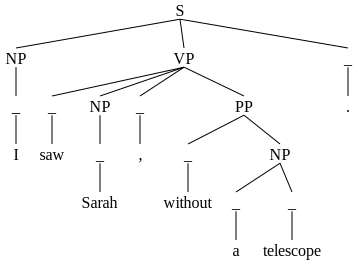

In [20]:
constituency_tree[1].values[2][0]

Como podemos ver, los datos del árbol de constituencia vienen en un objeto tipo Tree, este objeto proviene de la arquitectura de árbol de nltk. Podemos crear una función que nos devuelva la estructura en tipo lista y así poder procesarlo más fácil.

In [11]:
constituency_tree.values[2]

AttributeError: Property values unavailable!

In [10]:
def tree_to_list(tree):
    if isinstance(tree, str):  # base case: leaf node
        return tree
    return [tree.label()] + [tree_to_list(child) for child in tree]

In [11]:
def is_list(obj):
    return isinstance(obj, list)

In [12]:
tree = tree_to_list(constituency_tree.values[2][0])

In [13]:
tree

['S',
 ['NP', ['_', 'I']],
 ['VP',
  ['_', 'saw'],
  ['NP', ['_', 'Sarah']],
  ['PP', ['_', 'with'], ['NP', ['_', 'a'], ['_', 'telescope']]]],
 ['_', '.']]

In [28]:
subtree = tree[0:-1]

In [29]:
subtree

['S',
 ['NP', ['_', 'I']],
 ['VP',
  ['_', 'saw'],
  ['NP', ['_', 'Sarah']],
  ['PP', ['_', 'with'], ['NP', ['_', 'a'], ['_', 'telescope']]]]]

We are going to create a dictionary to put as label of each node the name that we are going to use in the language model

In [14]:
phrase_mapper = {
    'S' : 'Sentence',
    'NP' : 'Noun Phrase',
    'VP' : 'Verb Phrase',
    'PP' : 'Prepositional Phrase',
    'ADJP' : 'Adjective Phrase',
    'ADVP' : 'Adverb Phrase',
    'SBAR' : 'Subordinate Clause',
    'PRT' : 'Particle',
    'INTJ' : 'Interjection',
    'CONJP' : 'Conjunction Phrase',
    'LST' : 'List Marker',
    'UCP' : 'Unlike Coordinated Phrase',
    'PRN' : 'Parenthetical',
    'FRAG' : 'Fragment',
    'X' : 'Unknown'
}

In [55]:
tree

['S',
 ['NP', ['_', 'I']],
 ['VP',
  ['_', 'saw'],
  ['NP', ['_', 'Sarah']],
  ['PP', ['_', 'with'], ['NP', ['_', 'a'], ['_', 'telescope']]]],
 ['_', '.']]

In [15]:
sentence = ['I', 'saw', 'Sarah', 'with', 'a', 'telescope','.']

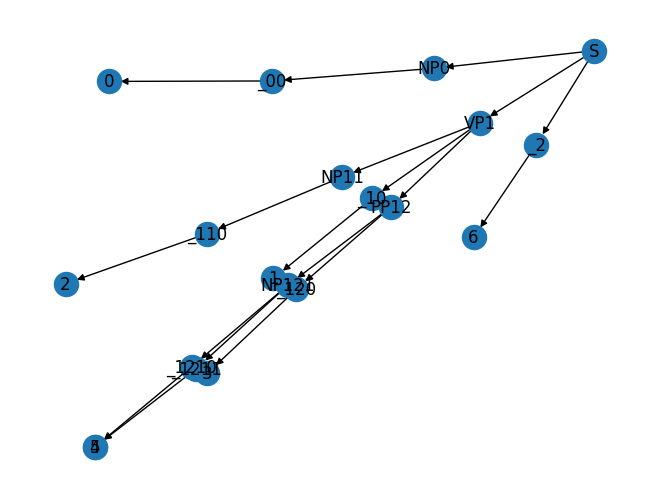

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

def add_edges(graph, node_list, parent_id='', sentence=sentence):
    parent = node_list[0] + parent_id
    if not parent in graph:
        graph.add_node(str(parent), label=phrase_mapper[str(parent)])
    children = node_list[1:]
    for i, child in enumerate(children):
        if isinstance(child, list):
            child_id = parent_id + str(i)
            graph.add_node(str(child[0]) + str(child_id), label=child[0])
            graph.nodes[str(child[0]) + str(child_id)]['label'] = phrase_mapper[graph.nodes[str(child[0]) + str(child_id)]['label']] if graph.nodes[str(child[0]) + str(child_id)]['label'] in phrase_mapper else child[0]
            graph.add_edge(parent, child[0] + child_id)
            add_edges(graph, child, parent_id=child_id, sentence = sentence)
        else:
            counter = sentence.index(child)
            graph.add_node(counter, label=child)
            graph.nodes[counter]['label'] = phrase_mapper[child] if child in phrase_mapper else child
            graph.add_edge(parent, counter)

def list_to_graph(node_list):
    G = nx.DiGraph()
    add_edges(G, node_list, sentence=sentence)
    return G

# Example usage:
graph_list = tree
G = list_to_graph(graph_list)

nx.draw_kamada_kawai(G, with_labels=True)
plt.show()

In [17]:
G.nodes(data=True)

NodeDataView({'S': {'label': 'Sentence'}, 'NP0': {'label': 'Noun Phrase'}, '_00': {'label': '_'}, 0: {'label': 'I'}, 'VP1': {'label': 'Verb Phrase'}, '_10': {'label': '_'}, 1: {'label': 'saw'}, 'NP11': {'label': 'Noun Phrase'}, '_110': {'label': '_'}, 2: {'label': 'Sarah'}, 'PP12': {'label': 'Prepositional Phrase'}, '_120': {'label': '_'}, 3: {'label': 'with'}, 'NP121': {'label': 'Noun Phrase'}, '_1210': {'label': '_'}, 4: {'label': 'a'}, '_1211': {'label': '_'}, 5: {'label': 'telescope'}, '_2': {'label': '_'}, 6: {'label': '.'}})

In [19]:
def remove_nodes_and_reconnect(graph):
    nodes_to_remove = [node for node in graph.nodes() if str(node).startswith('_')]
    for node in nodes_to_remove:
        # Get the parents and children of the node
        parents = list(graph.predecessors(node))
        children = list(graph.successors(node))
        
        # Connect each parent node to each child node
        for parent in parents:
            for child in children:
                # Add an edge from parent to child
                graph.add_edge(parent, child)
        
        # Remove the node
        graph.remove_node(node)

# Example usage:
remove_nodes_and_reconnect(G)

In [43]:
G.nodes(data=True)

NodeDataView({'S': {'label': 'Sentence'}, 'NP0': {'label': 'Noun Phrase'}, 'I': {'label': 'I'}, 'VP1': {'label': 'Verb Phrase'}, 'saw': {'label': 'saw'}, 'NP11': {'label': 'Noun Phrase'}, 'Sarah': {'label': 'Sarah'}, 'PP12': {'label': 'Prepositional Phrase'}, 'with': {'label': 'with'}, 'NP121': {'label': 'Noun Phrase'}, 'a': {'label': 'a'}, 'telescope': {'label': 'telescope'}})

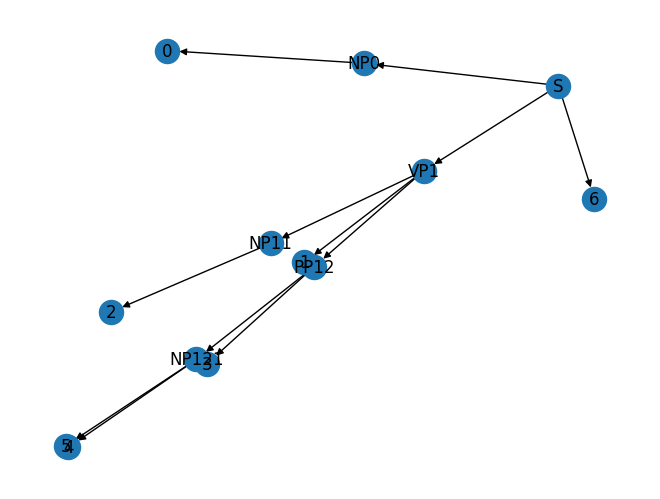

In [20]:
nx.draw_kamada_kawai(G, with_labels=True)
plt.show()

In [19]:
G.nodes(data=True)

NodeDataView({'S': {}, 'NP0': {}, 'I': {}, 'VP1': {}, 'saw': {}, 'NP11': {}, 'Sarah': {}, 'PP12': {}, 'with': {}, 'NP121': {}, 'a': {}, 'telescope': {}})

Tenemos que crear nodos adicionales para representar el grafo de constituencia, ya que al contrario que los árboles sintácticos y semánticos, aquí las palabras no se relacionan entre ellas mediante relaciones de dependencia, sino que un conjunto de palabras se insertan en un grupo determinado dentro de la oración, como puede ser el predicado nominal o el predicado verbal.

In [ ]:
for node in G.nodes():
    node_name =
    if node in phrase_mapper:
        G.nodes[node]['label'] = phrase_mapper[node]